In [1]:
# Set things up for later.
from numpy import *
import scipy.stats as stats
from scipy.optimize import minimize_scalar

# We set ourselves up for plots
import matplotlib.pyplot as plt
%matplotlib inline 

# Timing
from timeit import default_timer as timer

In [2]:
# See the notebook ES-Margins-Basics for derivation of these formulae
def ExpectedShortfallLogNormal(mu, sigma, lambd):
    es = -(1.0/lambd)*exp(mu+sigma*sigma*0.5)*stats.norm.cdf(stats.norm.ppf(lambd)-sigma)
    return es

def ExpectedShortfallNegativeLogNormal(mu, sigma, lambd):
    return (1.0/lambd)*exp(mu+sigma*sigma*0.5)*(1-stats.norm.cdf(stats.norm.ppf(1-lambd)-sigma))


In [3]:
print(ExpectedShortfallLogNormal(0,1,0.01))
print(ExpectedShortfallNegativeLogNormal(0,1,0.01))


-0.07253717078081977
15.227960300878138


## Expected shortfall for a Forward contract in Black-Scholes World
We consider a forward contract which allows the purchase of one unit of a (risky) asset at a future time $T>t$ for $K$ units of currency. 
We assume that time-value of money is given by a risk-free asset
$$dB_t = r B_t\,dt\,,\,\,\, B_0 = 1$$

The contract payoff (at time $T$) is $S_T - K$. 
The fair present value of this is $p_t = S_t - \frac{B_t}{B_T}K$. 
We consider a trader who sold such contract. 

While no model for risky asset is needed to price forward contracts (the price follows form no-arbitrage reasoning in a model-free way), we do need a model to assess the risk.
We assume that in the real world measure we have 
$$dS_t = \mu S_t\, dt + \sigma S_t \,dW_t\,,\,\,\,S_0 = S\,.$$



### One step
At time $t+\tau$ (with $\tau > 0$ small) we have $p_{t+\tau} = S_{t+\tau} - \frac{B_{t+\tau}}{B_T}K$.
Thus, due to cash invariance
$$\text{ES}_\lambda(-p_{t+\tau}) = \text{ES}_\lambda(-S_{t+\tau}) - \frac{B_{t+\tau}}{B_T}K\,.$$

We can solve the SDE for $(S_t)$ with Ito formula to get
$$S_{t+\tau} = S_t\exp\left((\mu-\frac12 \sigma^2)\tau + \sigma(W_{t+\tau}-W_t)\right)\,.$$
Recall that $W_{t+\tau}-W_t \sim \sqrt{\tau}N(0,1)$. 
Thus, with positive homogenienty of expected shortfall,
$$\text{ES}_\lambda(-p_{t+\tau}) = S_t \, \text{ES}_\lambda(-X) - \frac{B_{t+\tau}}{B_T}K\,,$$
where $X:=\exp(\bar \mu + \bar \sigma Z)$, with $Z\sim N(0,1)$ 


and with $\bar \mu := (\mu-\frac12 \sigma^2)\tau$,  $\bar \sigma := \sigma \sqrt{\tau}$.

In [4]:
# in a long contract we get the asset S and pay the price K at time T.
def LongFwdPrice(S, K, r, T):
    return S - exp(-r*T)*K

def LongFwdFairStrike(S,r,T):
    return S*exp(r*T)

def BSShortFwdMargin(lambd, tau, S, K, r, mu, sigma, T):
    barMu = (mu-0.5*sigma*sigma)*tau; barSigma = sqrt(tau)*sigma;
    esLogNegNorm = ExpectedShortfallNegativeLogNormal(barMu,barSigma,lambd);
    esMargin = S*esLogNegNorm - K*exp(-r*(T-tau));
    #print(esMargin);
    return esMargin;

#BlackScholesLongFwdMargin(p, tau, riskyPath[(i+1)*ScaleFactor], K, r, sigma, T-MarginTimeGrid[i+1])

def BSLongFwdMargin(lambd, tau, S, K, r, mu, sigma, T):
    barMu = (mu-0.5*sigma*sigma)*tau; barSigma = sqrt(tau)*sigma;
    #print("Direct muBar %.5f and sigmaBar %.5f" % (barMu, barSigma))
    esLogNorm = ExpectedShortfallLogNormal(barMu,barSigma,lambd);
    esMargin = S*esLogNorm + K*exp(-r*(T-tau));
    return esMargin;

def BSPortfolioFwdMargin(lambd, tau, S, r, mu, sigma, 
                         longNotionals, longStrikes, longExercise, 
                         shortNotionals, shortStrikes, shortExercise):
    alpha = -sum(shortNotionals)+sum(longNotionals);
    beta = 0.0;
    for i in range (0, len(shortNotionals)):
        beta = beta - shortNotionals[i]*exp(-r*(shortExercise[i]-tau))*shortStrikes[i];
    
    for i in range (0, len(longNotionals)):
        beta = beta + longNotionals[i]*exp(-r*(longExercise[i]-tau))*longStrikes[i];
    
    #print('alpha=%.2f, beta=%.2f' % (alpha, beta))
    
    barMu = (mu-0.5*sigma*sigma)*tau; barSigma = sqrt(tau)*sigma;
    esMargin = 0.0;
    if (alpha >= 0.0):
        esLogNorm = ExpectedShortfallLogNormal(barMu,barSigma,lambd);
        esMargin = alpha*S*esLogNorm + beta;
    else:
        esNegLogNorm = ExpectedShortfallNegativeLogNormal(barMu,barSigma,lambd);
        esMargin = -alpha*S*esNegLogNorm + beta;
    return esMargin;

In [5]:
# Let's have a look at a long position i.e. fwd payoff is S_T - K. 
# this situation our liability is K - S_T which is at most K (since S_T is always > 0)

S = 100; r = 0.0; mu = 0.; T = 1.0; sigma = 1.5;
tau = 1.0/365.25; 
lambd = 0.01;
K = LongFwdFairStrike(S, r, T)

longFwdMargin = BSLongFwdMargin(lambd, tau, S, K, r, mu, sigma, T)
print("LongFwdMargin %.3f" % longFwdMargin)

# Now for a short forward i.e. payoff K - S_T.
# In this situation our liability is S_T - K and since S_T can be arbitrarily large, our liability is arbitrarily large
shortFwdMargin = BSShortFwdMargin(lambd, tau, S, K, r, mu, sigma, T)
print("ShortFwdMargin %.3f" % shortFwdMargin)
print("Clearly margin for long should be less than margin for short and we see this is: %r." % (longFwdMargin <= shortFwdMargin))

LongFwdMargin 19.101
ShortFwdMargin 22.925
Clearly margin for long should be less than margin for short and we see this is: True.


In [27]:
# Let's see the margin in terms of P&L

def RiskFactorCalculator(sigma, lambd, tau, mu):
    """
    params to calculate risk Factor
    Returns a list of float numbers [riskFatorShort, riskFatorlong]
    """
    muBar = (mu-0.5*sigma*sigma)*tau
    sigmaBar = sqrt(tau)*sigma
    #print("PandL muBar %.5f and sigmaBar %.5f" % (muBar, sigmaBar))
    riskFactorShort = ExpectedShortfallNegativeLogNormal(muBar, sigmaBar, lambd)-1.0
    riskFactorLong = ExpectedShortfallLogNormal(muBar, sigmaBar, lambd)+1.0
    print("Is short bigger: %r" % (riskFactorShort >= riskFactorLong)) #testing if short is larger than long
    
    return [riskFactorShort, riskFactorLong]


r = 0.0; mu = 0.0; T = 1.0; sigma = 3.;
#tau = 1.0/365.25; 
tau = 1.0 / 365.25 / 24
lambd = 0.01;

K_0 = 200;
K_1 = 200;

[riskFactorShort, riskFactorLong] = RiskFactorCalculator(sigma, lambd, tau, mu)
# print("Risk factor short %.10e, long %.10e" % (riskFactorShort, riskFactorLong))
print("Risk factor short %.8f, long %.8f" % (riskFactorShort, riskFactorLong))
print("Risk factor short - long %.8f" % (riskFactorShort - riskFactorLong))

# Say I entered a long at K_0
marginLongFromPandL = K_0 - K_1 + K_1*riskFactorLong
marginLongDirect = BSLongFwdMargin(lambd, tau, K_1, K_0, r, mu, sigma, T)
print("LongFwdMargin direct %.3f and LongFwdMarginPandL %.3f" % (marginLongDirect, marginLongFromPandL))

# Say I entered a short at K_0
marginShortFromPandL = K_1 - K_0 + K_1*riskFactorShort
marginShortDirect = BSShortFwdMargin(lambd, tau, K_1, K_0, r, mu, sigma, T)
print("ShortFwdMargin direct %.3f and ShortFwdMarginPandL %.3f" % (marginShortDirect, marginShortFromPandL))

# initial margin scaling factor
alpha_init = 0.5
print("Vol = %.2f, Shorts: initial %.3f, maintenance %.3f" % (sigma,(1+alpha_init)*marginShortFromPandL, marginLongFromPandL))






Is short bigger: True
Risk factor short 0.08864696, long 0.08227992
Risk factor short - long 0.00636704
LongFwdMargin direct 16.456 and LongFwdMarginPandL 16.456
ShortFwdMargin direct 17.729 and ShortFwdMarginPandL 17.729
Vol = 3.00, Shorts: initial 26.594, maintenance 16.456


In [7]:
# Set up some basic parameters
S = 100; r = 0.05; mu = 0.1; T = 1.0;
longStrikes = [LongFwdFairStrike(S, r, T)];
longNotionals = [1.0];
longExercise = [T];

N = 250;
tau = T/N;
sigma = 0.1;


print("long only")
print(BSPortfolioFwdMargin(0.01, tau, S, r, sigma, 
                         longNotionals, longStrikes, longExercise, 
                         [], [], []))

print(BSLongFwdMargin(0.01,tau,S,LongFwdFairStrike(S, r, T),r,sigma,T))

print("short only")
shortStrikes = [LongFwdFairStrike(S, r, T)];
shortNotionals = [1.0];
shortExercise = [T];

print(BSPortfolioFwdMargin(0.01, tau, S, r, sigma, 
                         [], [], [], 
                         shortNotionals, shortStrikes, shortExercise))

print(BSShortFwdMargin(0.01,tau,S,LongFwdFairStrike(S, r, T),r,sigma,T))

print("long and short - should net fully!")
print(BSPortfolioFwdMargin(0.01, tau, S, r, sigma, 
                         longNotionals, longStrikes, longExercise, 
                         shortNotionals, shortStrikes, shortExercise))



long only


TypeError: BSPortfolioFwdMargin() missing 1 required positional argument: 'shortExercise'

In [7]:
# Set up some basic parameters
S = 100.0; r = 0.05; mu = 0.1; T = 1.0;
K = LongFwdFairStrike(S, r, T);
N = 365*24;
tau = T/N;
sigma = .7;

lambdaVals = linspace(0.001,0.2,100)
marginValuesLong = BSLongFwdMargin(lambdaVals, tau, S, K, r, sigma, T)
marginValuesShort = BSShortFwdMargin(lambdaVals, tau, S, K, r, sigma, T)

plt.plot(lambdaVals, marginValuesLong, '-r', label='Long fwd')
plt.plot(lambdaVals, marginValuesShort, '-g', label='Short fwd')
plt.title('Margin amount - fwd with price %.2f' % LongFwdPrice(S,K,r,T))
plt.ylabel('Margin amount');
plt.xlabel('lambda');
plt.legend();
margin = BSLongFwdMargin(0.01, tau, S, K, r, sigma, T)
print("To be 99%% sure that there is no loss until next margin call we need margin %.2f" % margin)
print("This is %.2f %% of the trade price" % (100.*margin/K))



TypeError: BSLongFwdMargin() missing 1 required positional argument: 'T'

TypeError: BSShortFwdMargin() missing 1 required positional argument: 'T'

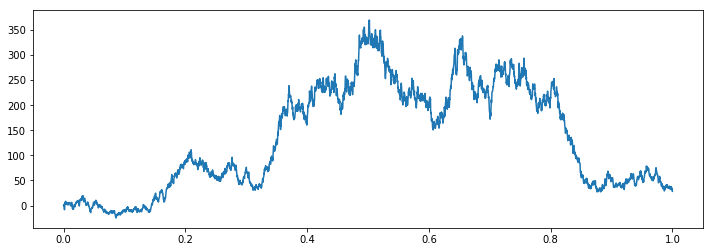

In [9]:
%run bs_paths.py

random.seed(8) # we want reproducibility for now

MarginCallsN = 365; # number of trading days in a year times hours
T = 1.0; # one year
tau = T/MarginCallsN; # margin call every day
pBar = 0.9999;

ScaleFactor = 10;
SimulationN = ScaleFactor*MarginCallsN;
dt = T/SimulationN;
S = 100;  r = 0.; mu = 0.1; sigma = 1.15;

# Start generating the path
simTimeGrid = linspace(0,T,SimulationN);
BSPathGen = BlackSholesPathGen(simTimeGrid, S, mu, sigma);
riskyPath = BSPathGen.GetPath();

K = LongFwdFairStrike(riskyPath[0],r,T);
longFwdPathGen = LongFwdValsGen(simTimeGrid, riskyPath, K, r, T);
longFwdVals = longFwdPathGen.GetPath();

plt.rcParams["figure.figsize"] = [12, 4];
plt.plot(simTimeGrid, longFwdVals, label='Liability')
    
# Now we calculate what would happen with the margin account    
MarginTimeGrid = linspace(0,T,MarginCallsN)
MarginValues = zeros(MarginCallsN);


MarginValues[0] = BSShortFwdMargin(1-pBar, tau, S, K, r, sigma, T)


# Conservative margin
gamma = 0.5; # we will multiply minimumMarginValues by 1+gamma for this type of account
phi = 0.8; # we will apply gamma * minimumMargin if minimumMargin > 0.9 * conservativeMargin
conservativeMargin = zeros(MarginCallsN);
conservativeMargin[0] = (1+gamma)*MarginValues[0];



Losses = zeros(MarginCallsN);
for i in range (0, MarginCallsN - 1):
    Losses[i+1] = max(longFwdVals[(i+1)*ScaleFactor] - MarginValues[i],0)
    p = pBar**(1.0/(MarginCallsN-i))
    #MarginValues[i+1] = BlackScholesLongFwdMargin(p, tau, riskyPath[(i+1)*ScaleFactor], K, r, sigma, T-MarginTimeGrid[i+1])
    MarginValues[i+1] = BSShortFwdMargin(1-pBar, tau, riskyPath[(i+1)*ScaleFactor], K, r, sigma, T-MarginTimeGrid[i+1])
    if (MarginValues[i+1] > phi * conservativeMargin[i]):
        conservativeMargin[i+1] = (1+gamma)*MarginValues[i+1];
    else:
        conservativeMargin[i+1] = conservativeMargin[i]
    
    
plt.plot(MarginTimeGrid, MarginValues, label='Min margin level')
plt.plot(MarginTimeGrid, conservativeMargin, label='Conservative margin level')

MarginValsDelta = MarginValues[0:(MarginCallsN-2)] - MarginValues[1:(MarginCallsN-1)]
conservativeMarginDelta = conservativeMargin[0:(MarginCallsN-2)] - conservativeMargin[1:(MarginCallsN-1)]
plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], MarginValsDelta, label='Changes in min margin')
plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], conservativeMarginDelta, label='Changes in conservative margin')

plt.legend();
print('Maximum loss %.2f' % max(Losses))



# Historical experiments with ETHBTC data 

In [10]:
def logReturns(S):
    return log(S/S.shift(1));

# assumes times come as unix times i.e. number of seconds from a date in the past
def volFromTimeSeriesPerSecond(prices, timeStamps):
    if (size(prices)<= 2):
        raise ValueError('we need more prices than 2')
    x = logReturns(prices)[1:]; # the value at the first index is NaN
    xBar = mean(x);
    deltaT = (timeStamps - timeStamps.shift(1))[1:]; # the value at the first index is NaN
    deltaT = deltaT/1000.0;     
    N = size(x);
    return sqrt(sum((x-xBar)*(x-xBar)/deltaT)/(N-1));

def volFromTimeSeriesPerHour(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*sqrt(3600.0)

def volFromTimeSeriesPerDay(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*sqrt(3600.0*24)

def volFromTimeSeriesPerYear(prices,timeStamps):
    return volFromTimeSeriesPerSecond(prices, timeStamps)*sqrt(3600.0*24*365.25)


In [11]:
import pandas as pd
from datetime import datetime

In [12]:
trades = pd.read_csv('../marketdata/binance/001/trades/ETHBTC-formatted_unixtimes.csv')

print("Total samples before removing duplicate timestamps :", trades.shape[0])

#deleting the equal ExactTimeStamps to avoid delta_t = 0
trades.drop_duplicates('ExactTimeStamp', keep='first', inplace=True)

print("Total samples after :", trades.shape[0])

firstTime = trades['ExactTimeStamp'][0]
firstTimeAsDatetime = datetime.utcfromtimestamp(firstTime/1000.0);
N = size(trades['ExactTimeStamp'])
lastTime = trades['ExactTimeStamp'][N-1]
lastTimeAsDatetime = datetime.utcfromtimestamp(lastTime/1000.0);
print("First day "+ firstTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))
print("Last day " + lastTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))



FileNotFoundError: [Errno 2] File b'../marketdata/binance/001/trades/ETHBTC-formatted_unixtimes.csv' does not exist: b'../marketdata/binance/001/trades/ETHBTC-formatted_unixtimes.csv'

In [13]:

prices = 1.0/trades['Price']
print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(prices, trades['ExactTimeStamp'])))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(prices, trades['ExactTimeStamp'])))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(prices, trades['ExactTimeStamp'])))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(prices, trades['ExactTimeStamp'])))

NameError: name 'trades' is not defined

In [22]:
midN=int(floor(N/2))
lastTime = trades['ExactTimeStamp'][midN]
lastTimeAsDatetime = datetime.utcfromtimestamp(lastTime/1000.0);
print("midle point time "+ firstTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))
volHistorical = volFromTimeSeriesPerYear(prices[1:midN], trades['ExactTimeStamp'][1:midN])
print("Annualized vol until middle point %.2f%% per year" % (100.0*volHistorical))

midle point time 2018-03-18 00:17:16
Annualized vol until middle point 1723.22% per year


In [14]:
%run bs_paths.py

prices = 1.0/trades['Price']

# assume zero interest rate
r = 0.0;

# margin call every minute
numTradesBetweenMarginCalls = 100 # i.e. roughly one margin call per minute
pBar = 0.99;

simTimeGrid = array(trades['ExactTimeStamp'][midN:N-1])/1000.0/60/60/24/365.25
simTimeGrid = simTimeGrid - simTimeGrid[0]
riskyPath = array(prices[midN:N-1])

T = simTimeGrid[simTimeGrid.size-1]
K = LongFwdFairStrike(riskyPath[0],r,T);



longFwdPathGen = LongFwdValsGen(simTimeGrid, riskyPath, K, r, T);
longFwdVals = longFwdPathGen.GetPath();

#plt.rcParams["figure.figsize"] = [9, 4];
plt.plot(simTimeGrid, longFwdVals, label='Liability (forward)')


# Now we calculate what would happen with the margin account    
MarginCallsN = int((size(simTimeGrid))/numTradesBetweenMarginCalls)
MarginValues = zeros(MarginCallsN);
MarginTimeGrid = zeros(MarginCallsN);


tau = 5.0/365.25/24/60/60;
print("Assumed time step as year fraction %.2e and in minutes %.2f" % (tau,tau*365.25*24*60))
MarginValues[0] = BSShortFwdMargin(1-pBar, tau, riskyPath[0], K, r, volHistorical, T)
print("Asset value %.2f, fair strike %.2f." % (riskyPath[0], K))
print("Margin amount %.3f." % MarginValues[0])


# Conservative margin
gamma = 0.5; # we will multiply minimumMarginValues by 1+gamma for this type of account
phi = 0.8; # we will apply gamma * minimumMargin if minimumMargin > 0.9 * conservativeMargin
conservativeMargin = zeros(MarginCallsN);
conservativeMargin[0] = (1+gamma)*MarginValues[0];

Losses = zeros(MarginCallsN);
for i in range (0, MarginCallsN - 1):
    MarginTimeGrid[i+1] = simTimeGrid[(i+1)*numTradesBetweenMarginCalls]
    
    # this is not correct as a different forward contract would have been entered ...
    Losses[i+1] = max(longFwdVals[(i+1)*numTradesBetweenMarginCalls] - MarginValues[i],0)
    
    MarginValues[i+1] = BSShortFwdMargin(1-pBar, tau, \
                            riskyPath[(i+1)*numTradesBetweenMarginCalls], K, r, volHistorical, \
                            T-simTimeGrid[(i+1)*numTradesBetweenMarginCalls])
    if (MarginValues[i+1] > phi * conservativeMargin[i]):
        conservativeMargin[i+1] = (1+gamma)*MarginValues[i+1];
    else:
        conservativeMargin[i+1] = conservativeMargin[i]
    
    
plt.plot(MarginTimeGrid, MarginValues, label='Min margin level')
plt.plot(MarginTimeGrid, conservativeMargin, label='Conservative margin level')

MarginValsDelta = MarginValues[0:(MarginCallsN-2)] - MarginValues[1:(MarginCallsN-1)]
conservativeMarginDelta = conservativeMargin[0:(MarginCallsN-2)] - conservativeMargin[1:(MarginCallsN-1)]
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], MarginValsDelta, label='Changes in min margin')
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], conservativeMarginDelta, label='Changes in conservative margin')

plt.legend();
plt.ylabel("ETH")
plt.xlabel("Time as year fraction")
print('Maximum loss %.2f' % max(Losses))
plt.title("ETHBTC Long fwd liability and margin evolution")
#plt.savefig('margin_on_binance_data-ETHBTC.eps', format='eps')




NameError: name 'trades' is not defined

<Figure size 864x288 with 0 Axes>

In [15]:
print("Margin amount over fair strike %.3f in percent." % (100.0*MarginValues[0]/K))

Margin amount over fair strike 0.000 in percent.


In [16]:
%run bs_paths.py

prices = trades['Price']

# assume zero interest rate
r = 0.0;

# margin call every minute
numTradesBetweenMarginCalls = 100 # i.e. roughly one margin call per minute
pBar = 0.999;

simTimeGrid = array(trades['ExactTimeStamp'][midN:N-1])/1000.0/60/60/24/365.25
simTimeGrid = simTimeGrid - simTimeGrid[0]
riskyPath = array(prices[midN:N-1])

T = simTimeGrid[simTimeGrid.size-1]
K = LongFwdFairStrike(riskyPath[0],r,T);



longFwdPathGen = LongFwdValsGen(simTimeGrid, riskyPath, K, r, T);
longFwdVals = longFwdPathGen.GetPath();

#plt.rcParams["figure.figsize"] = [9, 4];
plt.plot(simTimeGrid, longFwdVals, label='Liability (forward)')


# Now we calculate what would happen with the margin account    
MarginCallsN = int((size(simTimeGrid))/numTradesBetweenMarginCalls)
MarginValues = zeros(MarginCallsN);
MarginTimeGrid = zeros(MarginCallsN);


tau = 5.0/365.25/24/60/60;
print("Assumed time step as year fraction %.2e and in minutes %.2f" % (tau,tau*365.25*24*60))
MarginValues[0] = BSShortFwdMargin(1-pBar, tau, riskyPath[0], K, r, volHistorical, T)
print("Asset value %.2f, fair strike %.2f." % (prices[midN], K))
print("Margin amount %.3f." % MarginValues[0])


# Conservative margin
gamma = 0.5; # we will multiply minimumMarginValues by 1+gamma for this type of account
phi = 0.8; # we will apply gamma * minimumMargin if minimumMargin > 0.9 * conservativeMargin
conservativeMargin = zeros(MarginCallsN);
conservativeMargin[0] = (1+gamma)*MarginValues[0];

Losses = zeros(MarginCallsN);
for i in range (0, MarginCallsN - 1):
    MarginTimeGrid[i+1] = simTimeGrid[(i+1)*numTradesBetweenMarginCalls]
    Losses[i+1] = max(longFwdVals[(i+1)*numTradesBetweenMarginCalls] - MarginValues[i],0)
    
    MarginValues[i+1] = BSShortFwdMargin(1-pBar, tau, \
                            riskyPath[(i+1)*numTradesBetweenMarginCalls], K, r, volHistorical, \
                            T-simTimeGrid[(i+1)*numTradesBetweenMarginCalls])
    if (MarginValues[i+1] > phi * conservativeMargin[i]):
        conservativeMargin[i+1] = (1+gamma)*MarginValues[i+1];
    else:
        conservativeMargin[i+1] = conservativeMargin[i]
    
    
plt.plot(MarginTimeGrid, MarginValues, label='Min margin level')
plt.plot(MarginTimeGrid, conservativeMargin, label='Conservative margin level')

MarginValsDelta = MarginValues[0:(MarginCallsN-2)] - MarginValues[1:(MarginCallsN-1)]
conservativeMarginDelta = conservativeMargin[0:(MarginCallsN-2)] - conservativeMargin[1:(MarginCallsN-1)]
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], MarginValsDelta, label='Changes in min margin')
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], conservativeMarginDelta, label='Changes in conservative margin')

plt.legend();
plt.ylabel("BTC")
plt.xlabel("Time as year fraction")
print('Maximum loss %.2f' % max(Losses))
plt.title("BTCETH Long fwd liability and margin evolution")
plt.savefig('margin_on_binance_data-BTCETH.eps', format='eps')

NameError: name 'trades' is not defined

In [17]:
print("Margin amount over fair strike %.3f in percent." % (100.0*MarginValues[0]/K))

Margin amount over fair strike 0.000 in percent.


# Historical experiments with BTCUSD index data

In [18]:
#load the dataframe
trades = pd.read_csv('../marketdata/price_index_derebit_2018_07_18.csv')

In [19]:
%run bs_paths.py

In [20]:
now = trades.shape[0]
trades.head()

,ExactTimeStamp,Price
0,1458047983000,415.87
1,1458047989000,415.88
2,1458047995000,415.88
3,1458048001000,415.88
4,1458048007000,415.87


In [21]:
# drop duplicate time stamps
print("Total samples before :", trades.shape[0])

#deleting the equal ExactTimeStamps to avoid delta_t = 0
trades.drop_duplicates('ExactTimeStamp', keep='first', inplace=True)

print("Total samples after :", trades.shape[0])

firstTime = trades['ExactTimeStamp'][0]
firstTimeAsDatetime = datetime.utcfromtimestamp(firstTime/1000.0);
N = size(trades['ExactTimeStamp'])
lastTime = trades['ExactTimeStamp'][N-1]
lastTimeAsDatetime = datetime.utcfromtimestamp(lastTime/1000.0);
print("First "+ firstTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))
print("Last " + lastTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))

Total samples before : 12291042
Total samples after : 12290590
First 2016-03-15 13:19:43
Last 2018-07-18 08:51:12


In [22]:
prices = trades['Price']
timeStamps = trades['ExactTimeStamp']

print("Vol is %.2f%% per second" % (100.0*volFromTimeSeriesPerSecond(prices, timeStamps)))
print("Vol is %.2f%% per hour" % (100.0*volFromTimeSeriesPerHour(prices, timeStamps)))
print("Vol is %.2f%% per day" % (100.0*volFromTimeSeriesPerDay(prices, timeStamps)))
print("Vol is %.2f%% per year" % (100.0*volFromTimeSeriesPerYear(prices, timeStamps)))

Vol is 0.01% per second
Vol is 0.78% per hour
Vol is 3.84% per day
Vol is 73.41% per year


In [23]:
midN=int(floor(N/2))
lastTime = trades['ExactTimeStamp'][midN]
lastTimeAsDatetime = datetime.utcfromtimestamp(lastTime/1000.0);
print("midle point time "+ lastTimeAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))
volHistorical = volFromTimeSeriesPerYear(prices[1:midN], trades['ExactTimeStamp'][1:midN])
print("Annualized vol until middle point %.2f%% per year" % (100.0*volHistorical))

midle point time 2017-05-16 20:12:17
Annualized vol until middle point 33.25% per year


In [ ]:
N = midN+5245934+1
someDate = trades['ExactTimeStamp'][N-1]
someDateAsDatetime = datetime.utcfromtimestamp(someDate/1000.0);
print("some point time "+ someDateAsDatetime.strftime('%Y-%m-%d %H:%M:%S'))

some point time 2018-05-16 20:12:15


In [ ]:
%run bs_paths.py

# assume zero interest rate
r = 0.0;

# margin call every minute
numTradesBetweenMarginCalls = 100 # i.e. roughly one margin call per minute
pBar = 0.999;

simTimeGrid = array(trades['ExactTimeStamp'][midN:N-1])/1000.0/60/60/24/365.25
simTimeGrid = simTimeGrid - simTimeGrid[0]
riskyPath = array(prices[midN:N-1])

T = simTimeGrid[simTimeGrid.size-1]
K = LongFwdFairStrike(riskyPath[0],r,T);



longFwdPathGen = LongFwdValsGen(simTimeGrid, riskyPath, K, r, T);
longFwdVals = longFwdPathGen.GetPath();



# Now we calculate what would happen with the margin account    
MarginCallsN = int((size(simTimeGrid))/numTradesBetweenMarginCalls)
MarginValues = zeros(MarginCallsN);
MarginTimeGrid = zeros(MarginCallsN);

# we assume we only guarantee a risk-engine run every day
tau = 1.0/365.25;
print("Assumed time step as year fraction %.2e and in minutes %.2f" % (tau,tau*365.25*24*60))
MarginValues[0] = BSShortFwdMargin(1-pBar, tau, riskyPath[0], K, r, volHistorical, T)


# Conservative margin
gamma = 0.5; # we will multiply minimumMarginValues by 1+gamma for this type of account
phi = 0.8; # we will apply gamma * minimumMargin if minimumMargin > 0.9 * conservativeMargin
conservativeMargin = zeros(MarginCallsN);
conservativeMargin[0] = (1+gamma)*MarginValues[0];

Losses = zeros(MarginCallsN);
for i in range (0, MarginCallsN - 1):
    MarginTimeGrid[i+1] = simTimeGrid[(i+1)*numTradesBetweenMarginCalls]
    Losses[i+1] = max(longFwdVals[(i+1)*numTradesBetweenMarginCalls] - MarginValues[i],0)
    
    MarginValues[i+1] = BSShortFwdMargin(1-pBar, tau, \
                            riskyPath[(i+1)*numTradesBetweenMarginCalls], K, r, volHistorical, \
                            T-simTimeGrid[(i+1)*numTradesBetweenMarginCalls])
    if (MarginValues[i+1] > phi * conservativeMargin[i]):
        conservativeMargin[i+1] = (1+gamma)*MarginValues[i+1];
    else:
        conservativeMargin[i+1] = conservativeMargin[i]
    
    


In [ ]:

plt.plot(simTimeGrid, longFwdVals, label='Liability (forward)')
plt.plot(MarginTimeGrid, MarginValues, label='Min margin level')
plt.plot(MarginTimeGrid, conservativeMargin, label='Conservative margin level')

MarginValsDelta = MarginValues[0:(MarginCallsN-2)] - MarginValues[1:(MarginCallsN-1)]
conservativeMarginDelta = conservativeMargin[0:(MarginCallsN-2)] - conservativeMargin[1:(MarginCallsN-1)]
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], MarginValsDelta, label='Changes in min margin')
#plt.plot(MarginTimeGrid[1:(MarginCallsN-1)], conservativeMarginDelta, label='Changes in conservative margin')

plt.legend();
plt.ylabel("USD")
plt.xlabel("Time as year fraction")
print('Maximum loss %.2f' % max(Losses))
plt.title("USDBTC liability and margin evolution for forward")
#plt.savefig('margin_deribit_data-USDBTC.eps', format='eps')


In [ ]:
print("Asset value %.2f, fair strike %.2f." % (riskyPath[0], K))
print("Margin amount %.3f and as percentage %.3f." % (MarginValues[0],
                                                      (100*MarginValues[0]/riskyPath[0])))


In [ ]:
maxLossIdx = argmax(Losses)
print("Margin at time of loss %.0f" % MarginValues[maxLossIdx])
print(longFwdVals[(maxLossIdx+1)*numTradesBetweenMarginCalls])

# References
[Follmer, H. and Schied, A. - Convex and coherent risk measures, 2008](https://www.math.hu-berlin.de/~foellmer/papers/CCRM.pdf)

[Embrechts, P. and Wang, R. - Seven proofs for the subadditivity of expected shortfall, 2015](https://people.math.ethz.ch/~embrecht/ftp/Seven_Proofs.pdf)